In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# location to save figures
import os
cwd = os.getcwd()
figure_path = cwd + '/figures/'

# Abundance Matching

Build SHAM mocks for ECO and Resolve.

In [5]:
from eco_mocks.galaxy_abundance_functions import Eckert_2016_phi
from AbundanceMatching import *

In [6]:
# choose abundance function
phi_1 = Eckert_2016_phi(sample='ECO SMF double')

# tabulate stellar mass function
msample = 10**np.arange(5,12.0,0.1)
nsample = phi_1(msample)
af = AbundanceFunction(np.log10(msample), nsample, faint_end_first=True)

In [7]:
# load halo catalog
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from halotools import sim_manager
simname = 'vishnu_130'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol = 0.001,
                                        version_name='custom', halo_finder='Rockstar')
Lbox = np.array([130.0,130.0,130.0])

In [8]:
from eco_mocks.sham_model import DeconvolveSHAM

In [9]:
from halotools.empirical_models import SubhaloModelFactory
from halotools.empirical_models import Behroozi10SmHm
sm_model = DeconvolveSHAM(stellar_mass_function = phi_1, scatter=0.15, prim_galprop='stellar_mass',
                           prim_haloprop='halo_vpeak', Lbox=Lbox)
model_instance = SubhaloModelFactory(stellar_mass = sm_model)

In [10]:
sm_model = DeconvolveSHAM(stellar_mass_function = phi_1, scatter=0.15, prim_galprop='stellar_mass',
                          prim_haloprop='halo_vpeak', Lbox=Lbox)
model_instance = SubhaloModelFactory(stellar_mass = sm_model)

In [11]:
model_instance.populate_mock(halocat)
mock = model_instance.mock.galaxy_table

Error automatically detecting Lbox.


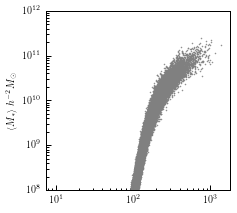

In [12]:
plt.figure(figsize=(3.3,3.3))
plt.plot(mock['halo_vpeak'], mock['stellar_mass'], '.', color='grey', ms=1)
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.ylim([10**8.0,10**12.0])
#plt.xlim([10**9,10**15])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [13]:
from eco_mocks.sham_model import DeconvolveSHAM, HaloProps, CAMGalProp, TertiaryGalProps
from eco_mocks.galaxy_abundance_functions import Eckert_2016_phi
from eco_mocks.galaxy_secondary_functions import prim_prop_nn
from eco_mocks.eco_galaxy_properties import eco_table as default_data

# some parameters to set for all models
Lbox = np.array([130.0,130.0,130.0])  # Vishnu box size
mstar_bins = 10**np.arange(5,12.0,0.1)  # stellar mass bins for CAM
mbary_bins = 10**np.arange(5,12.0,0.1)  # baryonic mass bins for CAM

####################################################################################
#### stellar mass based models
####################################################################################

#define galaxy selection function
def galaxy_selection_func(table, min_mass=10**8.0, max_mass=np.inf, prim_gal_prop='stellar_mass'):
    """
    define which galaxies should appear in the mock galaxy table

    Parameters
    ----------
    table : astropy.table object
        table containing mock galaxies
    """

    mask = (table[prim_gal_prop] >= min_mass) & (table[prim_gal_prop] < max_mass)
    return mask


class BaryonicMass(object):
    """
    class to add baryonic mass given stellar mass and fgas
    """

    def __init__(self, gas_fraction_key='fgas', **kwargs):
        """
        """

        self._mock_generation_calling_sequence = ['assign_baryonic_mass']
        self._galprop_dtypes_to_allocate = np.dtype([('baryonic_mass','f4'), ('gas_mass','f4')])
        self.list_of_haloprops_needed = []
        self.gas_fraction_key = gas_fraction_key

    def assign_baryonic_mass(self, **kwargs):
        """
        """

        table = kwargs['table']

        fg = table[self.gas_fraction_key]
        mstar = table['stellar_mass']

        table['gas_mass'] = (fg/(1.0-fg))*mstar
        table['baryonic_mass'] = mstar + table['gas_mass']

        return table


In [17]:
phi = Eckert_2016_phi(sample='ECO SMF double')
sm_model =  DeconvolveSHAM(stellar_mass_function = phi, scatter=0.15,
                           prim_galprop='stellar_mass', prim_haloprop='halo_vpeak', Lbox=Lbox)
additional_halo_properties = HaloProps()
color_dist = prim_prop_nn(prim_prop='stellar_mass', sec_prop='u_minus_r')
color_model = CAMGalProp('stellar_mass', mstar_bins, rho=-1.0,
                         secondary_haloprop='halo_half_mass_scale',
                         secondary_galprop='u_minus_r',
                         conditional_rvs=color_dist.rvs,
                         additional_galprop='reference_idx')
props_to_allocate = default_data.keys()
props_to_allocate.remove('stellar_mass')
props_to_allocate.remove('baryonic_mass')
props_to_allocate.remove('gas_mass')
props_to_allocate.remove('u_minus_r')
tertiaty_props = TertiaryGalProps(default_data, 'reference_idx', props_to_allocate)
baryonic_mass = BaryonicMass()
model_1a = SubhaloModelFactory(stellar_mass = sm_model,
                               haloprops = additional_halo_properties,
                               galaxy_color = color_model,
                               more_galaxy_properties = tertiaty_props,
                               baryonic_mass = baryonic_mass,
                               galaxy_selection_func = galaxy_selection_func,
                               model_feature_calling_sequence = ('stellar_mass', 'galaxy_color', 'haloprops',
                                                                 'more_galaxy_properties', 'baryonic_mass'))

In [18]:
#model_1a = SubhaloModelFactory(stellar_mass = sm_model)
model_1a.populate_mock(halocat)
mock = model_instance.mock.galaxy_table

Error automatically detecting Lbox.
100000.0000001 100000.0
